In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [25]:
# read data
housing = pd.read_csv('../data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **1. Add combine attribute**


In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / \
    housing['total_rooms']
housing['population_per_household'] = housing['population'] / \
    housing['households']
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20433 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


In [27]:
numberics_columns = housing.select_dtypes("float64").columns
# delete the target column
numberics_columns = numberics_columns.drop("median_house_value")
category_columns = housing.select_dtypes("object").columns

# **2. Split data into train and test**


In [28]:
# import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing.drop(
    "median_house_value", axis=1), housing["median_house_value"], test_size=0.2, random_state=42, stratify=housing["ocean_proximity"])


In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16512, 12), (4128, 12), (16512,), (4128,))

# **2. Construct a pipeline for preprocessing**


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [31]:
from sklearn.base import BaseEstimator, TransformerMixin


class OutlierReplacer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=numberics_columns)
        self.cols = numberics_columns
        self.upper_bound = {}
        self.lower_bound = {}
        for col in self.cols:
            q1, q3 = np.percentile(X[col], [25, 75])
            IQR = q3 - q1
            self.upper_bound[col] = q3 + 1.5 * IQR
            self.lower_bound[col] = q1 - 1.5 * IQR
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns=numberics_columns)
        for col in self.cols:
            X.loc[X[col] > self.upper_bound[col], col] = self.upper_bound[col]
            X.loc[X[col] < self.lower_bound[col], col] = self.lower_bound[col]
        return X

In [32]:
numberics_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier_removal', OutlierReplacer()),
    ('std_scaler', MinMaxScaler())
])

In [33]:
category_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
])

In [34]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('numberics', numberics_pipeline, numberics_columns),
    ('category', category_pipeline, category_columns)
])


In [35]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# **3. Select and train a model**


In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
lin_housing_prediction = lin_reg.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, lin_housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

65371.0388659213

In [37]:
from sklearn.svm import LinearSVR
linear_svr = LinearSVR()
linear_svr.fit(X_train_prepared, y_train)
linear_svr_housing_prediction = linear_svr.predict(X_test_prepared)
linear_svr_mse = mean_squared_error(y_test, linear_svr_housing_prediction)
linear_svr_rmse = np.sqrt(linear_svr_mse)
linear_svr_rmse


187706.35654316252

## **Test with Cross Validation**


In [38]:
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [39]:
from sklearn.model_selection import cross_val_score

linear_reg_scores = cross_val_score(
    lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

lin_reg_rmse_scores = np.sqrt(-linear_reg_scores)
display_scores(lin_reg_rmse_scores)


Scores: [65829.94271342 64681.36759534 66012.46416747 67119.85223977
 63121.27465146 63745.20463448 63455.20230614 66265.00518025
 66355.49688329 63394.76064543]
Mean: 64998.05710170524
Standard deviation: 1407.6247557087152


In [40]:
linear_svr_scores = cross_val_score(
    linear_svr, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
linear_svr_rmse_scores = np.sqrt(-linear_svr_scores)
display_scores(linear_svr_rmse_scores)


Scores: [188768.56504772 194853.89704918 193648.44421655 200986.46652456
 188526.23846556 188716.16961747 191332.90235981 192361.72576511
 191071.45586432 190827.47285929]
Mean: 192109.33377695808
Standard deviation: 3572.1807132345734


# **4. Hyperparameter Tuning**


In [41]:
from sklearn.model_selection import GridSearchCV
import math

C = np.logspace(-10, 10, 5)
epsilon = np.logspace(-10, 10, 5)
tol = np.logspace(-10, 10, 5)

linear_svr_param_grid = {
    'C': C,
    'epsilon': epsilon,
    'tol': tol,
}

linear_svr = LinearSVR()
linear_svr_search = GridSearchCV(linear_svr, linear_svr_param_grid,
                                 cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

linear_svr_search.fit(X_train_prepared, y_train)
print(linear_svr_search.best_params_)
print(math.sqrt(-linear_svr_search.best_score_))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
{'C': 100000.0, 'epsilon': 1e-05, 'tol': 1e-05}
66194.46361246958


# **5. Evaluate final model**


**Final result of Support Vector Machine Regressor**

In [42]:
lin_svr_final = linear_svr_search.best_estimator_
lin_svr_final_predictions = lin_svr_final.predict(X_test_prepared)
lin_svr_final_mse = mean_squared_error(y_test, lin_svr_final_predictions)
lin_svr_final_predictions_rmse = np.sqrt(lin_svr_final_mse)
lin_svr_final_predictions_rmse


66409.24993459217

**Visualize the results**


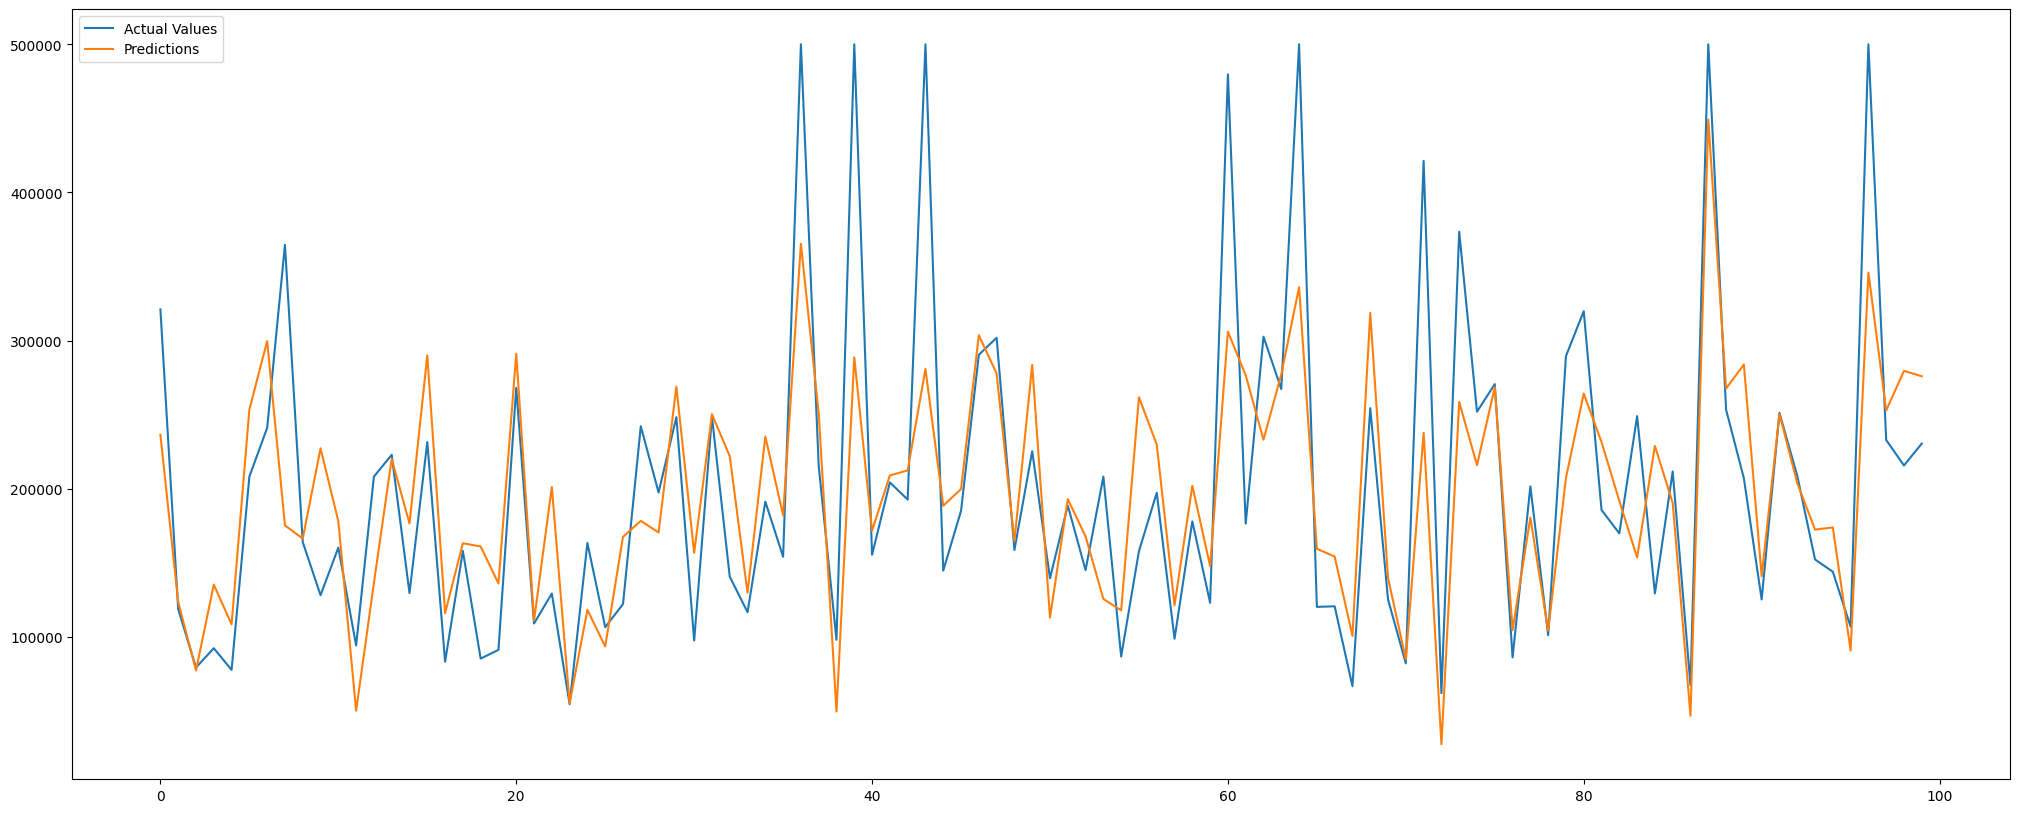

In [43]:
# plot final predictions vs actual values using line chart
plt.figure(figsize=(25, 10))
plt.plot(y_test.values[: 100], label="Actual Values")
plt.plot(lin_svr_final_predictions[: 100], label="Predictions")
plt.legend()

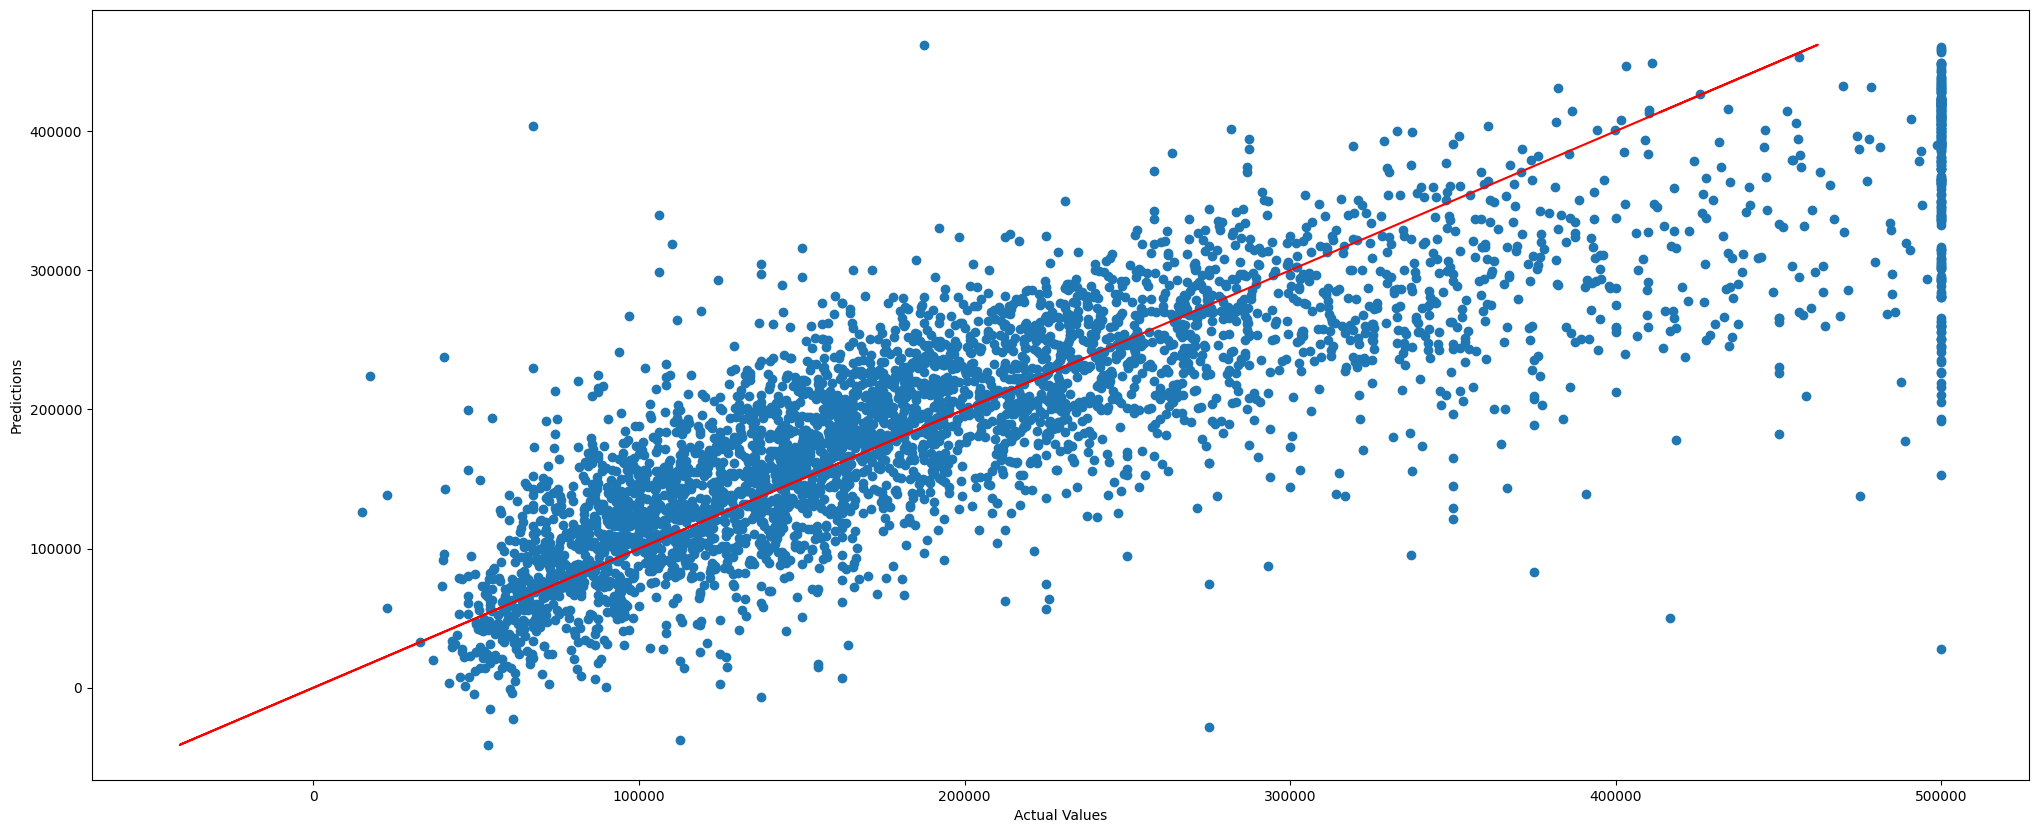

In [44]:
# plot final predictions vs actual values using scatter plot
plt.figure(figsize=(25, 10))
plt.scatter(y_test.values, lin_svr_final_predictions)
plt.plot(lin_svr_final_predictions, lin_svr_final_predictions, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.show()